In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import os
import sys
# nb_dir = os.path.split(os.getcwd())[0]
# if nb_dir not in sys.path:
#     sys.path.append(nb_dir)
    

nb_dir = os.getcwd()
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from wgand import AnomalyDetector, PcaAnomalyDetector
from wgand import load_tissue_graph, get_gdf
from wgand.utils import precision_at_k

In [4]:
from mlxtend.classifier import StackingCVClassifier
import networkx as nx
import pickle
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from karateclub.node_embedding.neighbourhood import Node2Vec
import xgboost as xgb
import lightgbm as lgb
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [5]:
def predict_anom(clf, X, method="linear"):
    clf.fit(X)
    return clf.predict_proba(X,method=method)[:,1:]

In [6]:
tissue_path = Path("Tissue Networks/")
models_path = Path("models")
out_path = Path("out")

In [7]:
disease_info = pd.read_csv("data/Disease_Info.csv")
disease_info["Disease_name"] = disease_info["Disease_name"].str.strip("{")
disease_info["Disease_name"] = disease_info["Disease_name"].str.strip("}")
disease_info["Disease_name"] = disease_info["Disease_name"].str.strip("?")
disease_info["Tissue"] = disease_info["Tissue"].str.replace("-", " ")

In [8]:
tissue_mapping = pd.read_csv("data/tissue_mapping_new.csv")


In [9]:
tissue_mapping = tissue_mapping.dropna()

In [10]:
tissue_mapping = tissue_mapping.merge(pd.DataFrame(disease_info.drop_duplicates(subset=["Tissue","Gene_ID"]).groupby("Tissue").size()), left_on="tissue_name_disease_file", right_on="Tissue", how="left")
tissue_mapping = tissue_mapping.rename(columns={0:"disease_nodes_num"})

In [11]:
tissue_mapping = tissue_mapping[tissue_mapping["disease_nodes_num"]>20]

In [12]:
tissue_mapping = tissue_mapping[~tissue_mapping.tissue_name_network_file.isin(["Breast Mammary Tissue", "Minor Salivary Gland"])]

## Generate Embedding

In [16]:
from karateclub.node_embedding.neighbourhood import RandNE

def get_embedding_model(g, emb_model):
    tissue_name = tissue_mapping.iloc[0]["tissue_name_network_file"]
    tissue_disease_file_name = tissue_mapping.iloc[0]["tissue_name_disease_file"]
    g = load_tissue_graph(tissue_name, tissue_disease_file_name)
    g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")
    for v, u in tqdm(g_num.edges, total=g_num.number_of_edges()):
        g_num[v][u].pop("weight")
        # g_num[v][u]["interaction"] =  g_num[v][u].pop("weight")


    model = emb_model()

    model.fit(g_num)
    return model

In [13]:
emb_model = "RandNE"
if (models_path/f"{emb_model}.pkl").exists():
    print("Loading embeddings")
    edge_df = pd.read_pickle(models_path/f"{emb_model}.pkl")
else:
    tissue_name = tissue_mapping.iloc[0]["tissue_name_network_file"]
    tissue_disease_file_name = tissue_mapping.iloc[0]["tissue_name_disease_file"]
    g = load_tissue_graph(tissue_name, tissue_disease_file_name)
    g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")
    edge_df = nx.convert_matrix.to_pandas_edgelist(g_num)
    edge_df["source"] = edge_df["source"].astype(int)
    edge_df["target"] = edge_df["target"].astype(int)
    edge_df = get_gdf(g)
    model = get_embedding_model(g, RandNE)
    edge_df["features"] = edge_df.apply(lambda x: np.concatenate([model.get_embedding()[int(x["source"])],model.get_embedding()[int(x["target"])]]), axis=1)
    edge_df.to_pickle(models_path/f"{emb_model}.pkl")

Loading embeddings


# Baseline 1

In [18]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from wgand.utils import precision_at_k
from pyod.models.iforest import IForest
warnings.filterwarnings('ignore')
res = []
predictions = []

# selected_tissue_mapping = tissue_mapping[tissue_mapping["tissue_name_network_file"].isin(short_list)]

for _, row in tqdm(tissue_mapping.iterrows(), total=len(tissue_mapping)):
    temp = {}
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")

    temp["Tissue Network"] = tissue_name
    temp["Tissue Disease File"] = tissue_name_disease_file
    if not Path(f"models/weighted_node2vec{tissue_name}.feather").exists():
        raise LookupError
    else:
        node_df = pd.read_feather(f"models/weighted_node2vec{tissue_name}.feather")
        node_df["tissue_name"] = tissue_name
    node_df["gen_name"] = node_df["node"].apply(lambda x: g_num.nodes[x]['gen'])
    clf = IForest(n_jobs=-1, random_state=2)
    X = np.stack(node_df["features"].values)
    probs = predict_anom(clf,X) 
    node_df["proba"] = probs
    node_df = node_df.sort_values("proba",ascending=False)
    predictions.append(node_df.drop(columns="features"))

    temp["auc"] = roc_auc_score(node_df["disease"].values, clf.predict_proba(X)[:,1])
    temp["p@1"] = node_df.iloc[:1].disease.sum()
    temp["p@3"] = node_df.iloc[:3].disease.sum()/3
    temp["p@10"] = node_df.iloc[:10].disease.sum()/10
    temp["p@20"] = node_df.iloc[:20].disease.sum()/20
    temp["p@40"] = node_df.iloc[:40].disease.sum()/40
    res.append(temp.copy())       
    # predictions.append(node_df.copy()) 

    # with tqdm(total=(len(link_clfs)*len(node_clfs)*len(selected_tissue_mapping))) as pbar:


  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
---------Brain Cerebellum-Brain Cerebellum--------
---------Brain Cortex-Brain Cortex--------
---------Brain Spinal cord cervical c 1-Spinal cord--------
---------Heart Atrial Appendage-Heart Atrium--------
---------Heart Left Ventricle-Heart Ventricle--------
---------Liver-Liver--------
---------Lung-Respiratory system Lung--------
---------Muscle Skeletal-Skeletal muscle--------
---------Nerve Tibial-Peripheral nerve--------
---------Ovary-Ovary--------
---------Pituitary-Pituitary--------
---------Skin Not Sun Exposed Suprapubic-Skin--------
---------Skin Sun Exposed Lower leg-Skin--------
---------Testis-Testis--------
---------Whole Blood-Blood and bone marrow--------
---------Whole Brain-Brain--------


In [19]:
baseline1_res = pd.DataFrame(res)
baseline1_res.mean()

auc     0.518178
p@1     0.000000
p@3     0.000000
p@10    0.011765
p@20    0.014706
p@40    0.010294
dtype: float64

In [22]:
baseline1_res

,Tissue Network,Tissue Disease File,auc,p@1,p@3,p@10,p@20,p@40
0,Artery Aorta,Artery Aorta,0.462882,0,0.0,0.0,0.00,0.025
1,Brain Cerebellum,Brain Cerebellum,0.524130,0,0.0,0.0,0.00,0.000
2,Brain Cortex,Brain Cortex,0.534219,0,0.0,0.0,0.00,0.000
3,Brain Spinal cord cervical c 1,Spinal cord,0.524940,0,0.0,0.0,0.05,0.025
4,Heart Atrial Appendage,Heart Atrium,0.557211,0,0.0,0.0,0.00,0.000
5,Heart Left Ventricle,Heart Ventricle,0.542867,0,0.0,0.0,0.00,0.000
6,Liver,Liver,0.417830,0,0.0,0.0,0.00,0.000
7,Lung,Respiratory system Lung,0.524405,0,0.0,0.1,0.05,0.025
8,Muscle Skeletal,Skeletal muscle,0.542828,0,0.0,0.0,0.00,0.000
9,Nerve Tibial,Peripheral nerve,0.514526,0,0.0,0.0,0.00,0.000


In [21]:
baseline1_res.to_csv(out_path/"baseline1_res.csv", index=False)

In [38]:
pd.concat(predictions, ignore_index=True).to_feather(out_path/"baseline_node2vec_iforest_preds.feather")

In [68]:
baseline_preds = pd.read_feather(out_path/"baseline_node2vec_iforest_preds.feather")

In [71]:
baseline_preds = baseline_preds.rename(columns={"tissue_name":"Tissue Network", "disease":"is_labeled_disease", "proba": "abnormality_score"})
baseline_preds["Method"] = "Node2Vec (Iforest)"
baseline_preds = baseline_preds.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])


In [72]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(baseline_preds.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [73]:
baseline_preds["P"] =list(pd.DataFrame(pk)["P"])
baseline_preds["K"] =list(pd.DataFrame(pk)["K"])

# Baseline 2 ODDBall

In [24]:
oddball_path = Path("../oddball_py3/out")

In [25]:
from collections import defaultdict
g_num = nx.convert_node_labels_to_integers(g, first_label=0, ordering='sorted', label_attribute="gen")
nx.write_edgelist(g_num, tissue_path/f"csv/{tissue_name}.csv", data=["weight"])
nodes_ids = list(g_num.nodes)
id_gene = {g_num.nodes[n]["gen"]: n for n in nodes_ids}
id_gene = defaultdict(lambda: -1, id_gene)
disease_info["node_id"] = disease_info.Gene_ID.apply(lambda x: id_gene[x])

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

res = []
oddball_predictions = []
for _, row in tqdm(tissue_mapping.iterrows()):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    temp = {"tissue_name":tissue_name}
    oddball_res_path = next(oddball_path.glob(f"{tissue_name}_0_1.*"))
    oddball_res = pd.read_csv(oddball_res_path, sep="\s", names=["node_id", "score"])
    oddball_res = oddball_res.merge(disease_info[disease_info.Tissue==tissue_name_disease_file][["node_id","Disease_name"]], on="node_id", how="left")
    oddball_res["is_disease"] = oddball_res.Disease_name.apply(lambda x: not pd.isna(x))
    
    scores = oddball_res["score"].values
    scaler = MinMaxScaler().fit(scores.reshape(-1, 1))
    probs = scaler.transform(scores.reshape(-1, 1)).ravel().clip(0, 1)
    scores = oddball_res["score"].values
    # print(f"÷{tissue_name}: {precision_at_k(oddball_res.is_disease,oddball_res.score, 20, True)}, AUC:{roc_auc_score(oddball_res.is_disease, probs)}")
    temp["AUC"] = roc_auc_score(oddball_res.is_disease, probs)
    temp["P@1"] = precision_at_k(oddball_res.is_disease,oddball_res.score, 1, True)
    temp["P@3"] = precision_at_k(oddball_res.is_disease,oddball_res.score, 3, True)
    temp["P@10"] = precision_at_k(oddball_res.is_disease,oddball_res.score, 10, True)
    temp["P@20"] = precision_at_k(oddball_res.is_disease,oddball_res.score, 20, True)
    res.append(temp)
    oddball_res["tissue_name"] = tissue_name
    oddball_predictions.append(oddball_res)



0it [00:00, ?it/s]

In [28]:
oddball_res = pd.DataFrame(res)
oddball_res.mean()

AUC     0.591284
P@1     0.176471
P@3     0.078431
P@10    0.076471
P@20    0.052941
dtype: float64

In [29]:
oddball_res.to_csv(out_path/"oddball_res.csv", index=False)

In [62]:
oddball_preds = pd.concat(oddball_predictions, ignore_index=True)

In [61]:
oddball_preds.to_feather(out_path/"baseline_oddball_preds.feather")

In [64]:
oddball_preds = oddball_preds.rename(columns={"tissue_name":"Tissue Network", "is_disease":"is_labeled_disease", "score": "abnormality_score"})
oddball_preds["Method"] = "OddBall"
oddball_preds = oddball_preds.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])


In [65]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(oddball_preds.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [66]:
oddball_preds["P"] =list(pd.DataFrame(pk)["P"])
oddball_preds["K"] =list(pd.DataFrame(pk)["K"])

# Ours

## Main (Ensemble)

In [14]:
from pyod.models.iforest import IForest
import pyod.models.combination as comb 
res = []
df_concat = []


for _, row in tqdm(tissue_mapping.iterrows(), total=len(tissue_mapping)):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    temp = {"tissue_name":tissue_name}
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)

        nodes = list(g.nodes)
        y = [1 if "disease_name" in g.nodes[n] else 0 for n in nodes ]
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    nad = AnomalyDetector(g, RandomForestRegressor(n_jobs=-1,n_estimators=500,random_state=2), IForest(n_jobs=-1,random_state=2))
    nad.set_gdf_features(edge_df["features"])
    nad.fit(nodes)
  
    probs = nad.predict_node_proba(nodes)

    temp["auc"] = roc_auc_score(y, probs)
    temp["p@1"] = precision_at_k(y, probs,1)
    temp["p@3"] = precision_at_k(y, probs,3)
    temp["p@10"] = precision_at_k(y, probs,10)
    temp["p@20"] = precision_at_k(y, probs,20)
    temp["p@anom"] = precision_at_k(y, probs,np.sum(y))
    temp["anom"] = np.sum(y)
    res.append(temp.copy())  
    df_concat.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs, "is_labeled_disease":y}))

  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------


In [35]:
pd.DataFrame(res).mean()

auc         0.670080
p@1         0.529412
p@3         0.372549
p@10        0.252941
p@20        0.214706
p@anom      0.099098
anom      142.941176
dtype: float64

In [33]:
pd.DataFrame(res).to_csv(out_path/"wagnd.csv", index=False)

In [39]:
wgand_preds = pd.concat(df_concat, ignore_index=True)
wgand_preds.to_feather(out_path/"wgand_preds.feather")

In [40]:
wgand_preds = wgand_preds.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])

In [41]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(wgand_preds.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [42]:
wgand_preds["P"] =list(pd.DataFrame(pk)["P"])
wgand_preds["K"] =list(pd.DataFrame(pk)["K"])

In [45]:
wgand_preds["Method"] = "WGAND (Ensemble)"


## Feature Comb

In [56]:
from pyod.models.iforest import IForest
import pyod.models.combination as comb 
res = []
feature_comb_preds = []


for _, row in tqdm(tissue_mapping.iterrows(), total=len(tissue_mapping)):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    temp = {"tissue_name":tissue_name}
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)

        nodes = list(g.nodes)
        y = [1 if "disease_name" in g.nodes[n] else 0 for n in nodes ]
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    nad = AnomalyDetector(g, RandomForestRegressor(n_jobs=-1,n_estimators=500,random_state=2), IForest(n_jobs=-1,random_state=2))
    nad.set_gdf_features(edge_df["features"])
    nad.fit(nodes)
  
    probs = nad.predict_feature_score(nodes)
    preds_df = pd.DataFrame({"node":nodes, "label":y, "feature_score":probs[:,0]})
    preds_df["tissue_name"] = tissue_name
    
    feature_comb_preds.append(preds_df)
    temp["auc"] = roc_auc_score(y, probs)
    temp["p@1"] = precision_at_k(y, probs,1)
    temp["p@3"] = precision_at_k(y, probs,3)
    temp["p@10"] = precision_at_k(y, probs,10)
    temp["p@20"] = precision_at_k(y, probs,20)
    temp["p@anom"] = precision_at_k(y, probs,np.sum(y))
    temp["anom"] = np.sum(y)
    res.append(temp.copy())  
    # df_concat.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs, "is_labeled_disease":y}))


  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------
---------Brain Cerebellum-Brain Cerebellum--------
---------Brain Cortex-Brain Cortex--------
---------Brain Spinal cord cervical c 1-Spinal cord--------
---------Heart Atrial Appendage-Heart Atrium--------
---------Heart Left Ventricle-Heart Ventricle--------
---------Liver-Liver--------
---------Lung-Respiratory system Lung--------
---------Muscle Skeletal-Skeletal muscle--------
---------Nerve Tibial-Peripheral nerve--------
---------Ovary-Ovary--------
---------Pituitary-Pituitary--------
---------Skin Not Sun Exposed Suprapubic-Skin--------
---------Skin Sun Exposed Lower leg-Skin--------
---------Testis-Testis--------
---------Whole Blood-Blood and bone marrow--------
---------Whole Brain-Brain--------


In [58]:
pd.DataFrame(res).mean()

auc         0.678703
p@1         0.294118
p@3         0.372549
p@10        0.223529
p@20        0.152941
p@anom      0.082182
anom      142.941176
dtype: float64

In [66]:
pd.DataFrame(res).to_csv(out_path/"feature_comb.csv", index=False)

In [59]:
feature_comb_preds = pd.concat(feature_comb_preds)

In [61]:
feature_comb_preds = feature_comb_preds.rename(columns={"feature_score":"abnormality_score",	"tissue_name":"Tissue Network", "label":"is_labeled_disease"})

In [62]:
feature_comb_preds = feature_comb_preds.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])


In [63]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(feature_comb_preds.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [64]:
feature_comb_preds["Method"] = "Feature Mean"
feature_comb_preds["P"] =list(pd.DataFrame(pk)["P"])
feature_comb_preds["K"] =list(pd.DataFrame(pk)["K"])

In [68]:
feature_comb_preds.reset_index().to_feather(out_path/"feature_comb_preds.feather")

## PCA

In [19]:
from pyod.models.iforest import IForest
import pyod.models.combination as comb 
res = []
df_pca = []


for _, row in tqdm(tissue_mapping.iterrows(), total=len(tissue_mapping)):
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    temp = {"tissue_name":tissue_name}
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    try:
        g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)

        nodes = list(g.nodes)
        y = [1 if "disease_name" in g.nodes[n] else 0 for n in nodes ]
    except KeyError:
        print(f"{tissue_name} not found in disease info")
        continue
    nad = PcaAnomalyDetector(g, RandomForestRegressor(n_jobs=-1,n_estimators=500,random_state=2))
    nad.set_gdf_features(edge_df["features"])
    # nad.train_weight_classifier()
    nad.fit()
    probs = nad.predict_proba(nodes)


    temp["auc"] = roc_auc_score(y, probs)
    temp["p@1"] = precision_at_k(y, probs,1)
    temp["p@3"] = precision_at_k(y, probs,3)
    temp["p@10"] = precision_at_k(y, probs,10)
    temp["p@20"] = precision_at_k(y, probs,20)
    temp["p@anom"] = precision_at_k(y, probs,np.sum(y))
    temp["anom"] = np.sum(y)
    res.append(temp.copy())  
    df_pca.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs[:,0], "is_labeled_disease":y}))


  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------


In [17]:
pd.DataFrame(res).mean()

auc         0.637900
p@1         0.352941
p@3         0.313725
p@10        0.194118
p@20        0.155882
p@anom      0.088132
anom      142.941176
dtype: float64

In [18]:
pd.DataFrame(res).to_csv(out_path/"pca.csv", index=False)

In [19]:
df_pca = pd.concat(df_pca, ignore_index=True)

In [20]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(df_pca.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [21]:
df_pca["Method"] = "PCA"
df_pca = df_pca.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])
df_pca["P"] =list(pd.DataFrame(pk)["P"])
df_pca["K"] =list(pd.DataFrame(pk)["K"])

In [22]:
df_pca.reset_index().to_feather(out_path/"pca_preds.feather")

## Iforest

In [75]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from wgand.utils import precision_at_k
from sklearn.model_selection import cross_validate
from pyod.models.iforest import IForest
import pyod.models.combination as comb 
from pyod.models.ecod import ECOD
from pyod.utils.utility import standardizer
from sklearn.decomposition import PCA
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
warnings.filterwarnings('ignore')
res = []
df_concat = []

# selected_tissue_mapping = tissue_mapping[tissue_mapping["tissue_name_network_file"].isin(short_list)]
selected_tissue_mapping = tissue_mapping
clfs = [IForest(n_jobs=-1, random_state=2), ECOD(n_jobs=-1), HBOS()]
clfs = [IForest(n_jobs=-1, random_state=2)]
for _, row in tqdm(selected_tissue_mapping.iterrows(), total=len(selected_tissue_mapping)):
    temp = {}
    tissue_name = row["tissue_name_network_file"]
    tissue_name_disease_file = row["tissue_name_disease_file"]
    print(f"---------{tissue_name}-{tissue_name_disease_file}--------")
    
    with (models_path/f"{tissue_name}_RandNE.pkl").open("rb") as f:
        nc = pickle.load( f)
    X, y, genes = nc.get_node_training_data(False, False,True)

    pca_tran = PCA(n_components=2, random_state=2).fit(X)
    X_pca = pca_tran.transform(X)
    
    scaler = MinMaxScaler().fit(X_pca[:,1:])
    probs_pca = scaler.transform(X_pca[:,1:]).ravel().clip(0, 1)
    clf = IForest(n_jobs=-1, random_state=2)
    # clf = ECOD(n_jobs=-1)
    # clf = HBOS()
    # clf = KNN()
    
    temp["tissue_name"]  = tissue_name     
    X = np.concatenate([X, X_pca], axis=1)
    
    probs = predict_anom(clf,X) 

    # probs = probs1*5 + probs2
    
    temp["p@1"] = precision_at_k(y, probs,1)
    temp["p@3"] = precision_at_k(y, probs,3)
    temp["p@10"] = precision_at_k(y, probs,10)
    temp["p@20"] = precision_at_k(y, probs,20)
    temp["p@anom"] = precision_at_k(y, probs,y.sum())
    temp["anom"] = y.sum()
    # temp["comb_method"] = combine.__name__
    res.append(temp.copy())  
    df_concat.append(pd.DataFrame({"Tissue Network":tissue_name, "abnormality_score": probs[:,0], "is_labeled_disease":y, "gene":genes}))
    # break
    # with tqdm(total=(len(link_clfs)*len(node_clfs)*len(selected_tissue_mapping))) as pbar:
# print(pd.DataFrame(res).mean() - iforest_res.mean()))

  0%|          | 0/17 [00:00<?, ?it/s]

---------Artery Aorta-Artery Aorta--------


NameError: name 'combine' is not defined

In [731]:
df_iforest = pd.concat(df_concat, ignore_index=True)

In [732]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(df_iforest.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [733]:
df_iforest["Method"] = "IForest"
df_iforest = df_iforest.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])
df_iforest["P"] =list(pd.DataFrame(pk)["P"])
df_iforest["K"] =list(pd.DataFrame(pk)["K"])

# Single Feature

In [267]:
# for tissue in tqdm(tissue_path.iterdir(), total=44):
#     tissue_name = tissue.stem.replace("_", " ")
import warnings
warnings.filterwarnings('ignore')
res = []
res_auc = []

with tqdm(total=(len(tissue_mapping))) as pbar:
    for _, row in selected_tissue_mapping.iterrows():
        tissue_name = row["tissue_name_network_file"]
        tissue_name_disease_file = row["tissue_name_disease_file"]
        with (models_path/f"{tissue_name}_RandNE.pkl").open("rb") as f:
            nc = pickle.load( f)
        
        df_agg = nc.get_node_features()
        # df_agg = df_agg.sample(frac=1, random_state=2).drop(columns=["id", "gen_name"])

        for feature in df_agg.columns.values[:-3]:
            temp = {"tissue_name": tissue_name}
            # for treshold in np.linspace(df_agg[feature].min(), df_agg[feature].max(), 50):
            df_agg = df_agg.sort_values(feature,ascending=False)
            temp["feature"] = feature
            temp["auc"] = roc_auc_score(df_agg["disease"],df_agg[feature])
            res_auc.append(temp)
            # for k in range(1,g.number_of_nodes()+1):
                # pk = precision_at_k(df_agg["disease"], df_agg[feature] > treshold,k)
            pk = precision_all_k(df_agg["disease"],df_agg[feature])
            pk = [{**{"tissue_name":tissue_name,"feature": feature},**line} for line in pk]
            res += pk
            # res.append({"tissue_name":tissue_name,"feature": feature, "K": k , "P": pk})

        pbar.update(1)
        

    # df = pd.DataFrame(res)
    # df.to_csv(out_path/"single.csv")

  0%|          | 0/17 [00:00<?, ?it/s]

In [271]:
auc_single = pd.DataFrame(res_auc).groupby("feature").mean()
auc_single = auc_single.sort_values("auc")

In [410]:
feature_comb_preds = pd.concat(feature_comb_preds)

In [411]:
feature_comb_preds = feature_comb_preds.rename(columns={"feature_avg":"abnormality_score",	"tissue_name":"Tissue Network", "disease":"is_labeled_disease"})

In [413]:
feature_comb_preds = feature_comb_preds.sort_values(["Tissue Network", "abnormality_score"], ascending=[1,0])


In [415]:
from wgand.utils import precision_all_k
pk = []
for _, data in tqdm(feature_comb_preds.groupby(["Tissue Network"])):
    pk+=precision_all_k(data["is_labeled_disease"].values, data["abnormality_score"].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [416]:
feature_comb_preds["Method"] = "Feature Mean"
feature_comb_preds["P"] =list(pd.DataFrame(pk)["P"])
feature_comb_preds["K"] =list(pd.DataFrame(pk)["K"])

In [417]:
feature_comb_preds

,id,gen_name,is_labeled_disease,abnormality_score,Tissue Network,Method,P,K
gen,,,,,,,,
3782,3782,ENSG00000115414,0,0.642215,Artery Aorta,Feature Mean,0.000000,1
5579,5579,ENSG00000133026,0,0.633411,Artery Aorta,Feature Mean,0.000000,2
10923,10923,ENSG00000175899,0,0.632038,Artery Aorta,Feature Mean,0.000000,3
8243,8243,ENSG00000157554,0,0.631137,Artery Aorta,Feature Mean,0.000000,4
2804,2804,ENSG00000106211,0,0.630890,Artery Aorta,Feature Mean,0.000000,5
...,...,...,...,...,...,...,...,...
3334,3334,ENSG00000111341,0,0.497544,Whole Brain,Feature Mean,0.041719,13519
10491,10491,ENSG00000172236,0,0.497503,Whole Brain,Feature Mean,0.041716,13520
8899,8899,ENSG00000163359,0,0.497492,Whole Brain,Feature Mean,0.041713,13521


In [419]:
#standardizer
pd.DataFrame(res_auc).mean()

auc         0.680678
p@1         0.294118
p@3         0.372549
p@10        0.217647
p@20        0.155882
p@anom      0.079024
anom      142.941176
dtype: float64

In [245]:
#sigmoid
pd.DataFrame(res_auc).groupby("comb_method").mean()

,auc,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,,
aom,0.658114,0.294118,0.372549,0.202941,0.145588,0.072585,142.941176
average,0.678686,0.294118,0.372549,0.223529,0.152941,0.082182,142.941176
maximization,0.643271,0.058824,0.019608,0.035294,0.041176,0.045159,142.941176
median,0.640199,0.294118,0.235294,0.135294,0.120588,0.075170,142.941176
moa,0.651538,0.294118,0.196078,0.100000,0.085294,0.053283,142.941176


In [279]:
# top 6
pd.DataFrame(res_auc).groupby("comb_method").mean()

,auc,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,,
aom,0.658977,0.323529,0.284314,0.144118,0.110294,0.061272,142.941176
average,0.680921,0.294118,0.372549,0.211765,0.150000,0.078658,142.941176
maximization,0.643271,0.058824,0.019608,0.035294,0.041176,0.045159,142.941176
median,0.668135,0.294118,0.235294,0.141176,0.135294,0.079250,142.941176
moa,0.658001,0.352941,0.196078,0.100000,0.079412,0.053358,142.941176


In [285]:
# top 8
pd.DataFrame(res_auc).groupby("comb_method").mean()

,auc,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,,
aom,0.651520,0.382353,0.264706,0.144118,0.110294,0.059496,142.941176
average,0.680530,0.294118,0.372549,0.217647,0.155882,0.079239,142.941176
maximization,0.643271,0.058824,0.019608,0.035294,0.041176,0.045159,142.941176
median,0.648342,0.294118,0.235294,0.129412,0.123529,0.079370,142.941176
moa,0.663117,0.294118,0.294118,0.129412,0.082353,0.054748,142.941176


In [298]:
# top 7
pd.DataFrame(res_auc).groupby("comb_method").mean()

,auc,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,,
aom,0.680678,0.294118,0.372549,0.217647,0.155882,0.079024,142.941176
average,0.680678,0.294118,0.372549,0.217647,0.155882,0.079024,142.941176
maximization,0.643271,0.058824,0.019608,0.035294,0.041176,0.045159,142.941176
median,0.650012,0.294118,0.235294,0.135294,0.126471,0.079973,142.941176
moa,0.643271,0.058824,0.019608,0.035294,0.041176,0.045159,142.941176


In [303]:
pd.DataFrame(res_auc).set_index("comb_method").loc["average"]

,tissue_name,auc,p@1,p@3,p@10,p@20,p@anom,anom
comb_method,,,,,,,,
average,Artery Aorta,0.860998,0.0,0.000000,0.1,0.05,0.043478,23
average,Brain Cerebellum,0.576345,0.0,0.000000,0.1,0.05,0.030769,65
average,Brain Cortex,0.743251,0.0,0.333333,0.1,0.15,0.090909,77
average,Brain Spinal cord cervical c 1,0.731265,0.0,0.333333,0.1,0.05,0.020833,48
average,Heart Atrial Appendage,0.806354,1.0,1.000000,0.6,0.45,0.172932,133
average,Heart Left Ventricle,0.789895,1.0,0.666667,0.6,0.45,0.173913,138
average,Liver,0.554578,0.0,0.000000,0.0,0.05,0.018868,53
average,Lung,0.699678,0.0,0.000000,0.0,0.00,0.094891,274
average,Muscle Skeletal,0.708767,1.0,1.000000,0.4,0.25,0.132231,121


# Graphs

In [ ]:
# df_concat = pd.read_feather(out_path/"pk_ours.feather")

In [ ]:
res = []
with tqdm(total=(len(tissue_mapping))) as pbar:
    for _, line in tissue_mapping.iterrows():
        tissue_name = line["tissue_name_network_file"]
        tissue_name_disease_file = line["tissue_name_disease_file"]

        try:
            g = load_tissue_graph(tissue_path, tissue_name, tissue_name_disease_file, disease_info)
        except KeyError:
            print(f"{tissue_name} not found in disease info")
            continue
        disease_num = len([1 for n in g.nodes if g.nodes[n]])
        for k in range(1,g.number_of_nodes()+1):
            res.append({"tissue_name":tissue_name,"feature": "Random", "K": k , "P": disease_num/g.number_of_nodes()})
        pbar.update(1)
df_random =pd.DataFrame(res)
df_random = df_random.rename(columns={"tissue_name":"Tissue Network","feature":"Method"})

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# ours_preds.Method = "Ours (IForest)"
df_pca.Method = "Ours (PCA)"
feature_comb_preds.Method = "Ours (Feature`s Mean)"
wgand_preds.Method = "Ours (Ensemble)"


In [452]:
df_concat = pd.concat([wgand_preds, baseline_preds, oddball_preds, df_random, feature_comb_preds, df_pca], ignore_index=True)

In [466]:
set(df_concat.Method)

{'Node2Vec (IForest)',
 'OddBall',
 'Ours (Ensemble)',
 'Ours (Feature`s Mean)',
 'Ours (IForest)',
 'Ours (PCA)',
 'Random'}

In [463]:
df_concat.Method = df_concat.Method.str.replace("Iforest", "IForest")

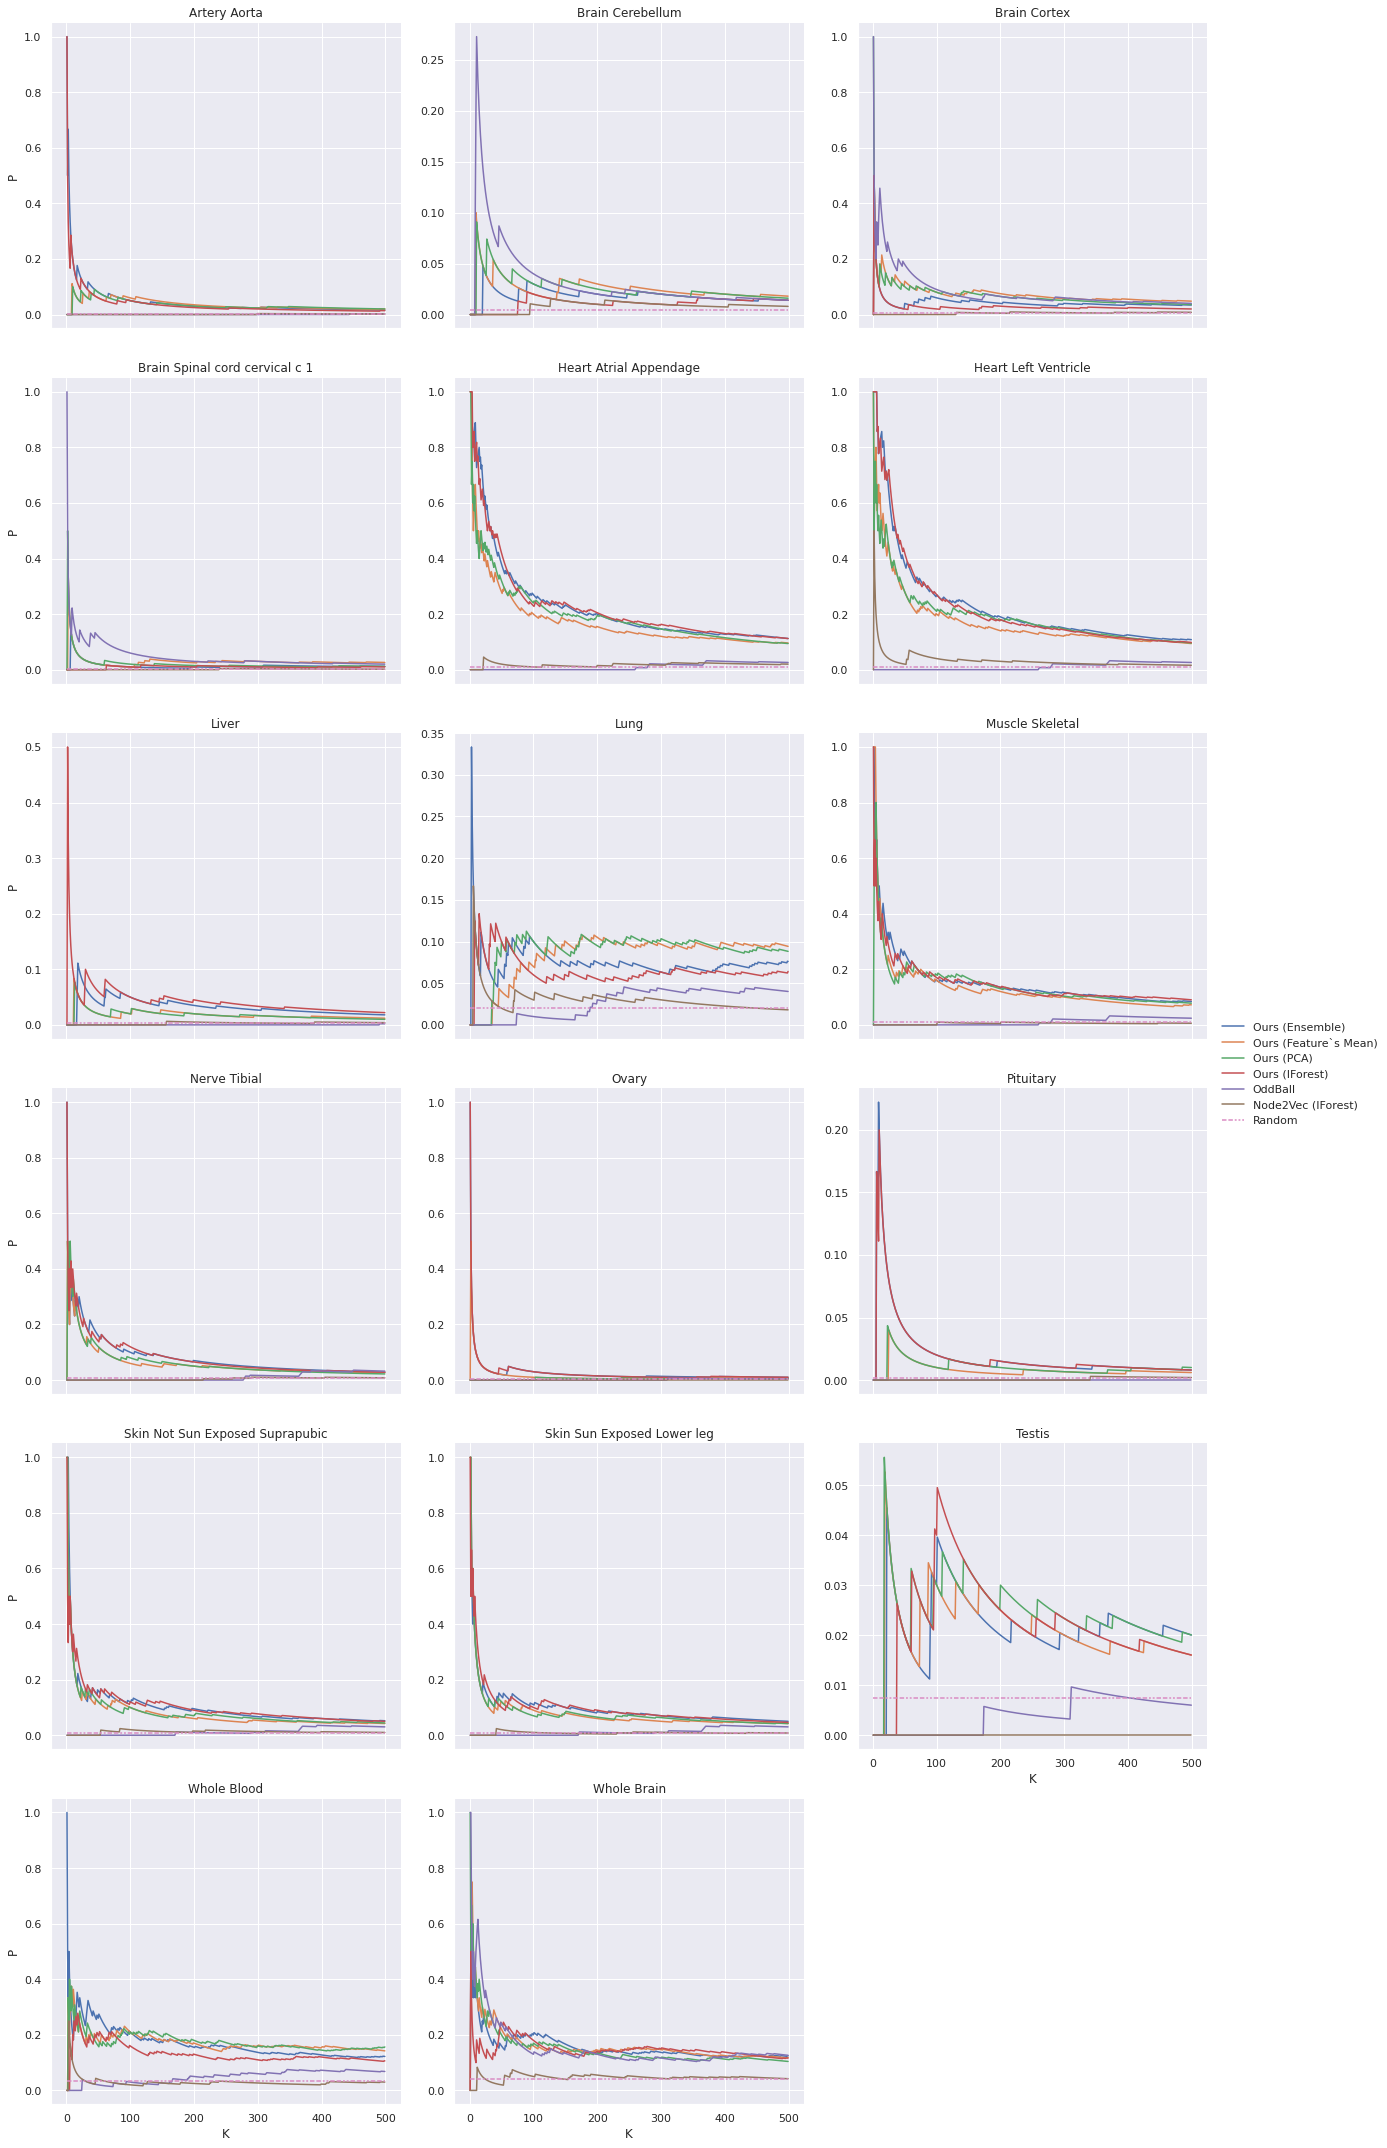

In [467]:
import seaborn as sns
sns.set_theme()
style = {f:"" for f in set(df_concat["Method"])}
style["Random"] =  (3, 1.25, 3, 1.25, 1.25, 1.25, 1.25, 1.25)
hue_order = ["Ours (Ensemble)", "Ours (Feature`s Mean)", "Ours (PCA)", "Ours (IForest)", "OddBall", "Node2Vec (IForest)", "Random"]
g = sns.relplot(data=df_concat[df_concat.K<500],x="K", y="P", hue="Method", col="Tissue Network", kind="line",col_wrap=3, dashes=style,style="Method", hue_order=hue_order, facet_kws={'sharey': False, 'sharex': True})

ax1 = g.fig.axes[0]
h,l =  ax1.get_legend_handles_labels()
g.legend.remove()
g.add_legend(dict(zip(l[0:7], h[0:7])))
# # legend = ax1.get_legend()
# # legend.remove()
# g.legend.remove()
# plt.legend(h[0:10],l[0:10], fontsize=13 , loc='outside right center')

for ax in g.axes:
    # ax.set_ylabel("Face-ism Index")
    # ax.set_xlabel("Century")
    ax.set_title(ax.title.get_text().replace('Tissue Network = ', ""))
            # facet_kws={'sharey': False, 'sharex': True}

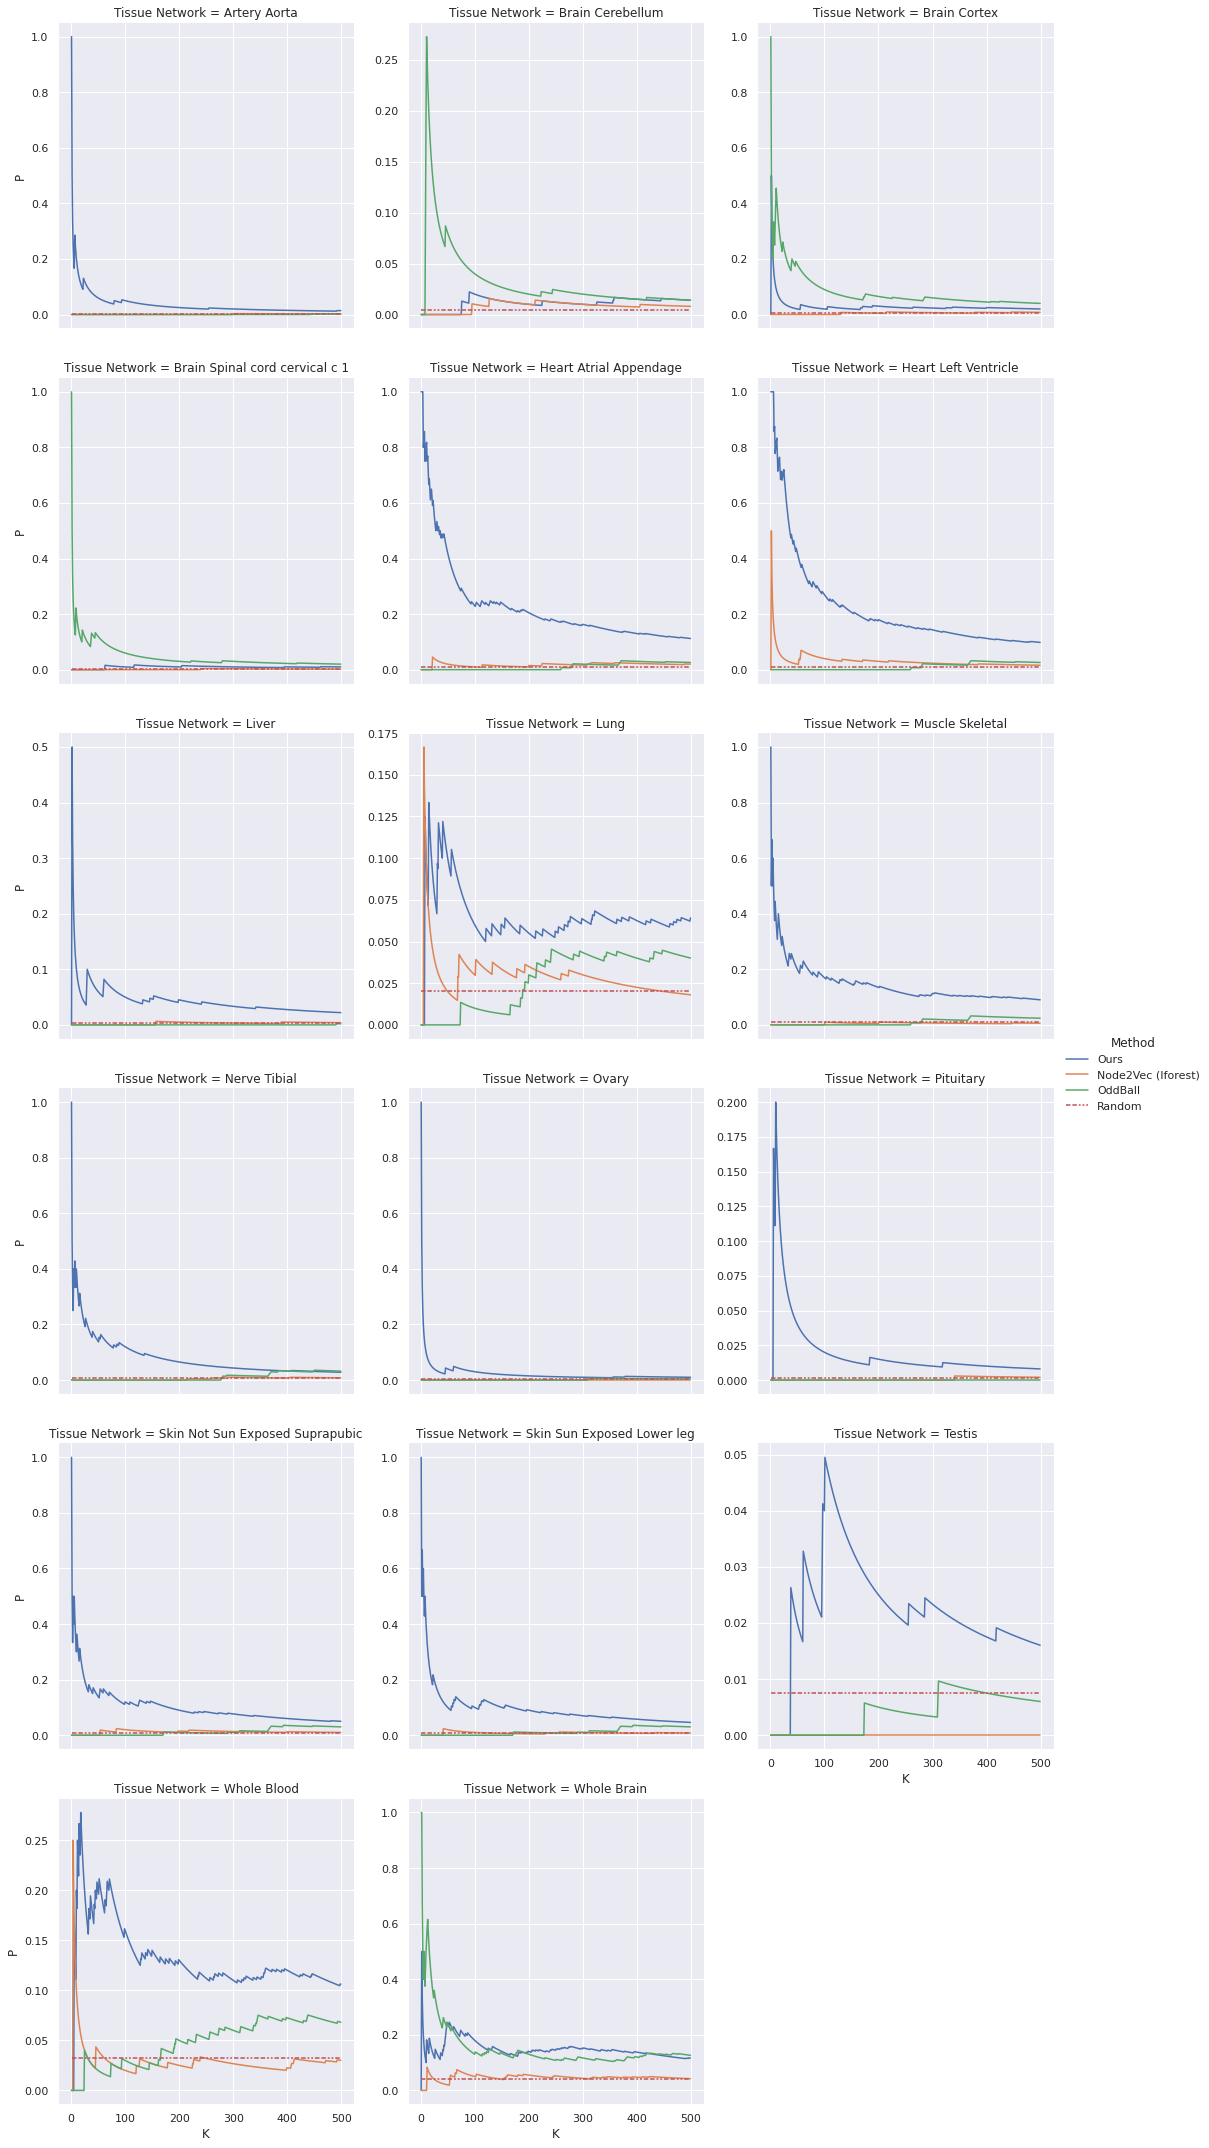

In [ ]:
import seaborn as sns
sns.set_theme()
style = {f:"" for f in set(df_concat["Method"])}
style["Random"] =  (3, 1.25, 3, 1.25, 1.25, 1.25, 1.25, 1.25)
g = sns.relplot(data=df_concat[df_concat.K<500],x="K", y="P", hue="Method", col="Tissue Network", kind="line",col_wrap=3, dashes=style,style="Method",  facet_kws={'sharey': False, 'sharex': True})
